# Mock Generation Summer 2022
Author: Benjamin Floyd

In [1]:
import json
import emcee
import corner
import glob
import re
import numpy as np
from astropy.table import Table, vstack, join, unique
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from schwimmbad import MultiPool
import astropy.units as u

%matplotlib inline

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Set up rng
seed = 123
rng = np.random.default_rng(seed)
print(f'Using RNG seed: {seed}')

Using RNG seed: 123


### Mock generation functions

In [2]:
def poisson_point_process(model, dx, dy=None, lower_dx=0, lower_dy=0):
    """
    Uses a spatial Poisson point process to generate AGN candidate coordinates.

    Parameters
    ----------
    model : float
        The model rate used in the Poisson distribution to determine the number of points being placed.
    dx, dy : int, Optional
        Upper bound on x- and y-axes respectively. If only `dx` is provided then `dy` = `dx`.
    lower_dx, lower_dy : int, Optional
        Lower bound on x- and y-axes respectively. If not provided, a default of 0 will be used

    Returns
    -------
    coord : np.ndarray
        Numpy array of (x, y) coordinates of AGN candidates
    """

    if dy is None:
        dy = dx

    # Draw from Poisson distribution to determine how many points we will place.
    p = stats.poisson(model * np.abs(dx - lower_dx) * np.abs(dy - lower_dy)).rvs(random_state=rng)

    # Drop `p` points with uniform x and y coordinates
    x = rng.uniform(lower_dx, dx, size=p)
    y = rng.uniform(lower_dy, dy, size=p)

    # Combine the x and y coordinates.
    coord = np.vstack((x, y))

    return coord

In [3]:
def model_rate(params, radial_dist, cluster_id):
    """
    Our generating model.

    Parameters
    ----------
    params : tuple of floats
        Tuple of parameters.
    radial_dist : array-like
        A vector of radii of objects relative to the cluster center
    cluster_id : int or str
        Used to select correct background prior

    Returns
    -------
    model : np.ndarray
        A surface density profile of objects as a function of radius.
    """

    # Unpack the parameters
    theta, beta, c0 = params
    rc = rc_true

    # In mock generation, we need to be able to skip adding the background surface density redshift relation.
    if cluster_id == -1:
        cz = 0.
    else:
        z = master_catalog['REDSHIFT'][master_catalog['SPT_ID'] == cluster_id][0]
        cz = c0 + delta_c(z) * num_clusters

    # Our amplitude will eventually be more complicated
    a = theta

    # Our model rate is an amplitude of cluster-specific trends with a radial dependence with a constant background rate.
    model = a * (1 + (radial_dist / rc) ** 2) ** (-1.5 * beta + 0.5) + cz

    return model

In [4]:
def generate_mock_cluster(cluster_catalog: Table, color_threshold: float, c_true: float) -> Table:
    # Background Catalog
    bkg_coords = poisson_point_process(c_true, dx=image_width)

    # Compute radial distances assuming the center of the image is the center of the cluster. In the future this will need to be generalized to the true cluster center.
    bkg_radii = np.sqrt((bkg_coords[0] - (image_width / 2))**2 + (bkg_coords[1] - (image_width / 2))**2)

    # Limit objects to within a max radius
    bkg_coords = bkg_coords[:, bkg_radii <= 2.5]
    bkg_radii = bkg_radii[bkg_radii <= 2.5]

    # Recast the SDWFS table as a Pandas Dataframe and use the sample method.
    sdwfs_agn_df = sdwfs_agn.to_pandas().sample(n=bkg_coords.shape[-1], weights=f'SELECTION_MEMBERSHIP_{color_threshold:.2f}', replace=True, random_state=rng)

    # Build a catalog of background information. For now, we will just grab the x,y coordinates, redshifts, completeness corrections, and selection memberships
    bkg_cat = Table([*bkg_coords, bkg_radii, sdwfs_agn_df['REDSHIFT'], sdwfs_agn_df['COMPLETENESS_CORRECTION'], sdwfs_agn_df[f'SELECTION_MEMBERSHIP_{color_threshold:.2f}']], names=['x', 'y', 'radial_dist', 'GALAXY_REDSHIFT', 'COMPLETENESS_CORRECTION', 'SELECTION_MEMBERSHIP'])

    # Add flag to background objects
    bkg_cat['CLUSTER_AGN'] = np.full_like(bkg_coords[0], False)

    # Cluster Catalog
    # Set an array of radii to generate model rates upon
    r_grid = np.linspace(0., 5., num=100)

    # Find the maximum rate of our model to use to for homogeneous Poisson process (Using c = 0.0 for a cluster-only model)
    max_rate = np.max(model_rate(params=(a_true, beta_true, 0.0), radial_dist=r_grid, cluster_id=-1))

    # Generate the homogenous Poisson process (Again, this will need to be done on pixel units in the future.)
    cl_coords = poisson_point_process(max_rate, dx=image_width)

    # Calculate the radii from the image center
    cl_radii = np.sqrt((cl_coords[0] - (image_width / 2))**2 + (cl_coords[1] - (image_width / 2))**2)

    # Limit to a max radius
    cl_coords = cl_coords[:, cl_radii <= 2.5]
    cl_radii = cl_radii[cl_radii <= 2.5]

    # Compute model rates at each candidate position
    rate_at_radius = model_rate(params=(a_true, beta_true, 0.), radial_dist=cl_radii, cluster_id=-1)

    # Perform rejection sampling
    prob_reject = rate_at_radius / max_rate
    alpha = rng.uniform(0., 1., size=len(rate_at_radius))
    cl_coords = cl_coords[:, prob_reject >= alpha]
    cl_radii = cl_radii[prob_reject >= alpha]

    # For the cluster, we need to select only objects within a redshift range of the cluster redshift.
    sdwfs_agn_at_z = sdwfs_agn[np.abs(sdwfs_agn['REDSHIFT'] - cluster_catalog['REDSHIFT']) <= cluster_catalog['REDSHIFT_UNC']]

    # Sample objects from the catalog.
    sdwfs_agn_at_z_df = sdwfs_agn_at_z.to_pandas().sample(n=cl_coords.shape[-1], weights=f'SELECTION_MEMBERSHIP_{color_threshold:.2f}', replace=True, random_state=rng)

    # Build catalog for cluster sources
    cl_cat = Table([*cl_coords, cl_radii, sdwfs_agn_at_z_df['REDSHIFT'], sdwfs_agn_at_z_df['COMPLETENESS_CORRECTION'], sdwfs_agn_at_z_df[f'SELECTION_MEMBERSHIP_{color_threshold:.2f}']], names=['x', 'y', 'radial_dist', 'GALAXY_REDSHIFT', 'COMPLETENESS_CORRECTION', 'SELECTION_MEMBERSHIP'])

    # Add flag to cluster objects
    cl_cat['CLUSTER_AGN'] = np.full_like(cl_coords[0], True)

    # Merge the catalogs
    los_cat = vstack([cl_cat, bkg_cat])

    # Add a cluster ID
    los_cat['SPT_ID'] = cluster_catalog['SPT_ID']

    # Add a column for the cluster redshift. (Using generic "REDSHIFT" to match real catalog expectation)
    los_cat['REDSHIFT'] = cluster_catalog['REDSHIFT']

    return los_cat

### Bayesian model functions

In [5]:
def lnlike(params: tuple[float, ...]):
    # Compute the likelihood value for each cluster
    cluster_like = []
    for cluster in master_catalog.group_by('SPT_ID').groups:
        cluster_id = cluster['SPT_ID'][0]
        # Compute the model rate at locations of the AGN.
        ri = cluster['radial_dist']
        ni = model_rate(params, ri, cluster_id)

        # Compute the ideal model rate at continuous locations
        rall = np.linspace(0., 2.5, num=10_000)
        nall = model_rate(params, rall, cluster_id)

        # We use a Poisson likelihood function
        ln_like_func = np.sum(np.log(ni * ri)) - np.trapz(nall * 2 * np.pi * rall, rall)
        cluster_like.append(ln_like_func)

    # Compute the total likelihood value
    total_ln_like = np.sum(cluster_like)
    return total_ln_like

In [6]:
def lnprior(params: tuple[float, ...]):
    # Extract the parameters
    theta, beta, c0 = params
    rc = rc_true

    cluster_prior = []
    for cluster in master_catalog.group_by('SPT_ID').groups:
        # Get the cluster redshift to set the background hyperparameters
        z = cluster['REDSHIFT'][0]
        h_c = agn_prior_surf_den(z) * num_clusters
        h_c_err = agn_prior_surf_den_err(z) * num_clusters

        # Shift background parameter to redshift-dependent value.
        cz = c0 + delta_c(z) * num_clusters

        # Define parameter ranges
        if (0. <= theta <= np.inf and
            -3. <= beta <= 3. and
            0. <= rc <= 0.5 and
            0. <= cz <= np.inf):
            theta_lnprior = 0.
            beta_lnprior = 0.
            rc_lnprior = 0.
            c_lnprior = -0.5 * np.sum((cz - h_c) ** 2 / h_c_err ** 2)
        else:
            theta_lnprior = -np.inf
            beta_lnprior = -np.inf
            rc_lnprior = -np.inf
            c_lnprior = -np.inf
        ln_prior_prob = theta_lnprior + beta_lnprior + rc_lnprior + c_lnprior
        cluster_prior.append(ln_prior_prob)

    total_lnprior = np.sum(cluster_prior)
    return total_lnprior

In [7]:
def lnprob(params: tuple[float, ...]):
    # Evaluate log-prior and test if we are within bounds
    lp = lnprior(params)

    if not np.isfinite(lp):
        return -np.inf

    return lnlike(params) + lp

## Generate mock catalog

In [ ]:
# Select out a number of clusters to use as examples
n_cl = 2

# Read in the SDWFS IRAGN catalog for use later
sdwfs_agn = Table.read('Data_Repository/Project_Data/SPT-IRAGN/Output/SDWFS_cutout_IRAGN.fits')

# Read in the SPT cluster catalog. We will use real data to source our mock cluster properties.
Bocquet = Table.read(f'Data_Repository/Catalogs/SPT/SPT_catalogs/2500d_cluster_sample_Bocquet18.fits')

# For the 20 common clusters between SPT-SZ 2500d and SPTpol 100d surveys we want to update the cluster information from
# the more recent survey. Thus, we will merge the SPT-SZ and SPTpol catalogs together.
Huang = Table.read(f'Data_Repository/Catalogs/SPT/SPT_catalogs/sptpol100d_catalog_huang19.fits')

# First we need to rename several columns in the SPTpol 100d catalog to match the format of the SPT-SZ catalog
Huang.rename_columns(['Dec', 'xi', 'theta_core', 'redshift', 'redshift_unc'],
                     ['DEC', 'XI', 'THETA_CORE', 'REDSHIFT', 'REDSHIFT_UNC'])

# Now, merge the two catalogs
SPTcl = join(Bocquet, Huang, join_type='outer')
SPTcl.sort(keys=['SPT_ID', 'field'])  # Sub-sorting by 'field' puts Huang entries first
SPTcl = unique(SPTcl, keys='SPT_ID', keep='first')  # Keeping Huang entries over Bocquet
SPTcl.sort(keys='SPT_ID')  # Resort by ID.

# Convert masses to [Msun] rather than [Msun/1e14]
SPTcl['M500'] *= 1e14
SPTcl['M500_uerr'] *= 1e14
SPTcl['M500_lerr'] *= 1e14

# Remove any unconfirmed clusters
SPTcl = SPTcl[SPTcl['M500'] > 0.0]

# For our masks, we will co-op the masks for the real clusters.
masks_files = [*glob.glob(f'Data_Repository/Project_Data/SPT-IRAGN/Masks/SPT-SZ_2500d/*.fits'),
               *glob.glob(f'Data_Repository/Project_Data/SPT-IRAGN/Masks/SPTpol_100d/*.fits')]

# Make sure all the masks have matches in the catalog
masks_files = [f for f in masks_files if re.search(r'SPT-CLJ\d+-\d+', f).group(0) in SPTcl['SPT_ID']]

# Select a number of masks at random, sorted to match the order in `full_spt_catalog`.
masks_bank = sorted([masks_files[i] for i in rng.choice(n_cl, size=n_cl)],
                    key=lambda x: re.search(r'SPT-CLJ\d+-\d+', x).group(0))

# Find the corresponding cluster IDs in the SPT catalog that match the masks we chose
spt_catalog_ids = [re.search(r'SPT-CLJ\d+-\d+', mask_name).group(0) for mask_name in masks_bank]
spt_catalog_mask = [np.where(SPTcl['SPT_ID'] == spt_id)[0][0] for spt_id in spt_catalog_ids]
selected_clusters = SPTcl['SPT_ID', 'RA', 'DEC', 'M500', 'REDSHIFT', 'THETA_CORE', 'XI', 'field'][spt_catalog_mask]

# We'll need the r500 radius for each cluster too.
selected_clusters['R500'] = (3 * selected_clusters['M500'] * u.Msun /
                             (4 * np.pi * 500 *
                              cosmo.critical_density(selected_clusters['REDSHIFT']).to(u.Msun / u.Mpc ** 3))) ** (1 / 3)

# Create cluster names
name_bank = [f'SPT_Mock_{i:03d}' for i in range(n_cl)]

# Combine our data into a catalog
SPT_data = selected_clusters.copy()
SPT_data.rename_columns(['SPT_ID', 'RA', 'DEC'], ['orig_SPT_ID', 'SZ_RA', 'SZ_DEC'])
SPT_data['SPT_ID'] = name_bank
SPT_data['MASK_NAME'] = masks_bank

In [ ]:
# Read in the purity and surface density files
with (open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_purity_color.json', 'r') as f,
      open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_background_prior_distributions.json', 'r') as g):
    sdwfs_purity_data = json.load(f)
    sdwfs_prior_data = json.load(g)
z_bins = sdwfs_purity_data['redshift_bins'][:-1]
threshold_bins = sdwfs_prior_data['color_thresholds'][:-1]

In [9]:
# Set up interpolators
agn_purity_color = interp1d(z_bins, sdwfs_purity_data['purity_90_colors'], kind='previous')
agn_surf_den = interp1d(threshold_bins, sdwfs_prior_data['agn_surf_den'], kind='previous')
agn_surf_den_err = interp1d(threshold_bins, sdwfs_prior_data['agn_surf_den_err'], kind='previous')

# For convenience, set up the function compositions
def agn_prior_surf_den(redshift: float) -> float:
    return agn_surf_den(agn_purity_color(redshift))

def agn_prior_surf_den_err(redshift: float) -> float:
    return agn_surf_den_err(agn_purity_color(redshift))

# Set up an interpolation for the AGN surface density relative to the reference surface density at z = 0
delta_c = interp1d(z_bins, agn_prior_surf_den(z_bins) - agn_prior_surf_den(0.), kind='previous')

In [10]:
cluster_redshifts = SPT_data['REDSHIFT']
redshift_uncert = SPT_data['REDSHIFT_UNC']

# For a cluster at z = 0.6, the color threshold will be [3.6] - [4.5] = 0.61
color_thresholds = [agn_purity_color(z) for z in cluster_redshifts]

# For now, we will set a fixed window size of 5'x5'. This will need to be generalized to use the mask files' WCS.
image_width = 5.

# We'll boost the number of objects in our sample by duplicating this cluster by a factor.
num_clusters = 50

# We will set our input (true) parameters to be an arbitrary value for cluster and using an approximation of the expected background surface density using our color threshold.
a_true = 2.5
beta_true = 1.0
rc_true = 0.1
c0_true = agn_prior_surf_den(0.)
c_truths = np.array([agn_prior_surf_den(z) for z in cluster_redshifts])

# We will amplify the true parameters by the number of clusters in the sample.
a_true *= num_clusters
c0_true *= num_clusters
c_truths *= num_clusters
print(f'Input parameters: {a_true = }, {beta_true = }, {rc_true = }, {c0_true = :.3f} ({c_truths = })')

Input parameters: a_true = 125.0, beta_true = 1.0, rc_true = 0.1, c0_true = 7.905 (c_truths = array([49.5235093, 49.5235093]))


### Run cluster realization pipeline

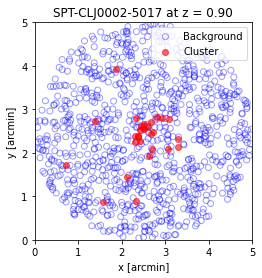

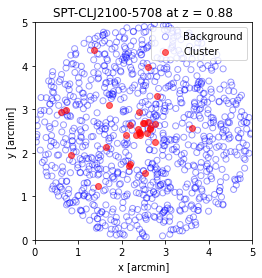

In [11]:
cluster_cats = []
for cluster_catalog, cluster_color_threshold, bkg_rate_true in zip(SPT_data, color_thresholds, c_truths):
    cat = generate_mock_cluster(cluster_catalog, cluster_color_threshold, bkg_rate_true)
    cluster_cats.append(cat)

    # Show plot of combined line-of-sight positions
    cluster_objects = cat[cat['CLUSTER_AGN'].astype(bool)]
    background_objects = cat[~cat['CLUSTER_AGN'].astype(bool)]
    _, ax = plt.subplots()
    ax.scatter(background_objects['x'], background_objects['y'], edgecolors='blue', facecolors='none', alpha=0.4, label='Background')
    ax.scatter(cluster_objects['x'], cluster_objects['y'], edgecolors='red', facecolors='red', alpha=0.6, label='Cluster')
    ax.legend()
    ax.set(title=f'{cluster_catalog["SPT_ID"]} at z = {cluster_catalog["REDSHIFT"]:.2f}', xlabel='x [arcmin]', ylabel='y [arcmin]', xlim=[0, image_width], ylim=[0, image_width], aspect=1)
    plt.show()

# Combine all catalogs
master_catalog = vstack(cluster_cats)

## Apply Bayesian model to refit data

In [12]:
# Set up walkers
ndim = 3
nwalkers = 50
nsteps = 5000

# Initialize walker positions
# pos0 = np.array([rng.normal(a_true, 1e-4, size=nwalkers), rng.normal(beta_true, 1e-4, size=nwalkers), rng.normal(rc_true, 1e-4, size=nwalkers), rng.normal(c_true, 1e-4, size=nwalkers)]).T
pos0 = np.array([rng.normal(a_true, 1e-4, size=nwalkers), rng.normal(beta_true, 1e-4, size=nwalkers), rng.normal(c0_true, 1e-4, size=nwalkers)]).T

with MultiPool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=ndim, log_prob_fn=lnprob, pool=pool)
    sampler.run_mcmc(pos0, nsteps=nsteps, progress=True)

print(f'Mean autocorrelation time: {(mean_tau := np.mean(sampler.get_autocorr_time())):.2f} steps\n', f'Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}')

100%|██████████| 5000/5000 [02:43<00:00, 30.59it/s]


Mean autocorrelation time: 40.84 steps
 Mean acceptance fraction: 0.638


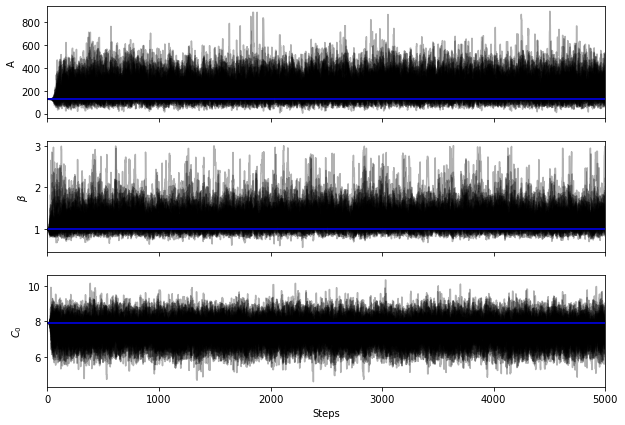

In [13]:
# Plot chains
samples = sampler.get_chain()
labels = ['A', r'$\beta$', r'$C_0$']
truths = [a_true, beta_true, c0_true]
_, axes = plt.subplots(nrows=ndim, figsize=(10, 7), sharex='col')
for i, (ax, label, truth) in enumerate(zip(axes.flatten(), labels, truths)):
    ax.plot(samples[:, :, i], 'k', alpha=0.3)
    ax.axhline(y=truth, c='b')
    ax.set(ylabel=label, xlim=[0, len(samples)])
axes[-1].set(xlabel='Steps')
plt.show()

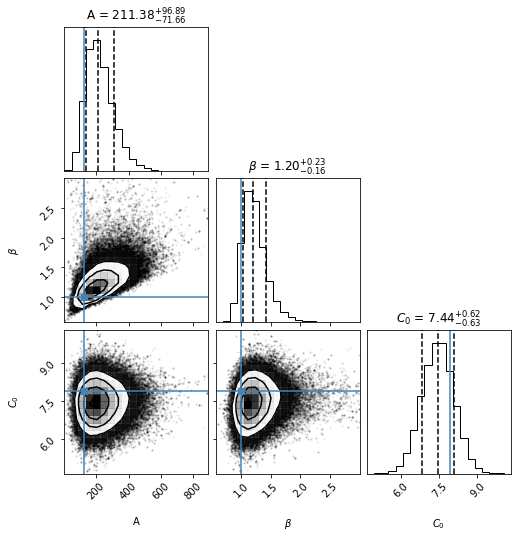

In [14]:
# Plot posterior
flat_samples = sampler.get_chain(discard=int(3*mean_tau), flat=True)
fig = corner.corner(flat_samples, labels=labels, truths=truths, show_titles=True, quantiles=[0.16, 0.5, 0.84])